In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly as py
import datetime
import glob
import seaborn as sns
import haversine as hs
import folium
import mpl_toolkits
import networkx as nx
import nxviz as nv
import janitor
import warnings
import plotly.express as px

from fiona.crs import from_epsg
from geopy import distance
from geopy.distance import geodesic
from sklearn.cluster import KMeans
from shapely.geometry import Point
from math import cos, asin, sin, atan2, sqrt, radians
from mpl_toolkits.basemap import Basemap
from networkx.drawing.nx_agraph import graphviz_layout
from nxviz import ArcPlot
from nxviz import annotate
from nxviz import CircosPlot
#from nxviz import GeoPlot
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from statsmodels.distributions.empirical_distribution import ECDF
from itertools import combinations

warnings.filterwarnings('ignore')

C:\Users\sowre\Anaconda3\lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.2 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.2, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
########## Reading only the voyages in service 1 ##########
service1_df = pd.read_csv("Service_1.csv", header = 0)
service1_df = service1_df.query('schedule in [1,2]')

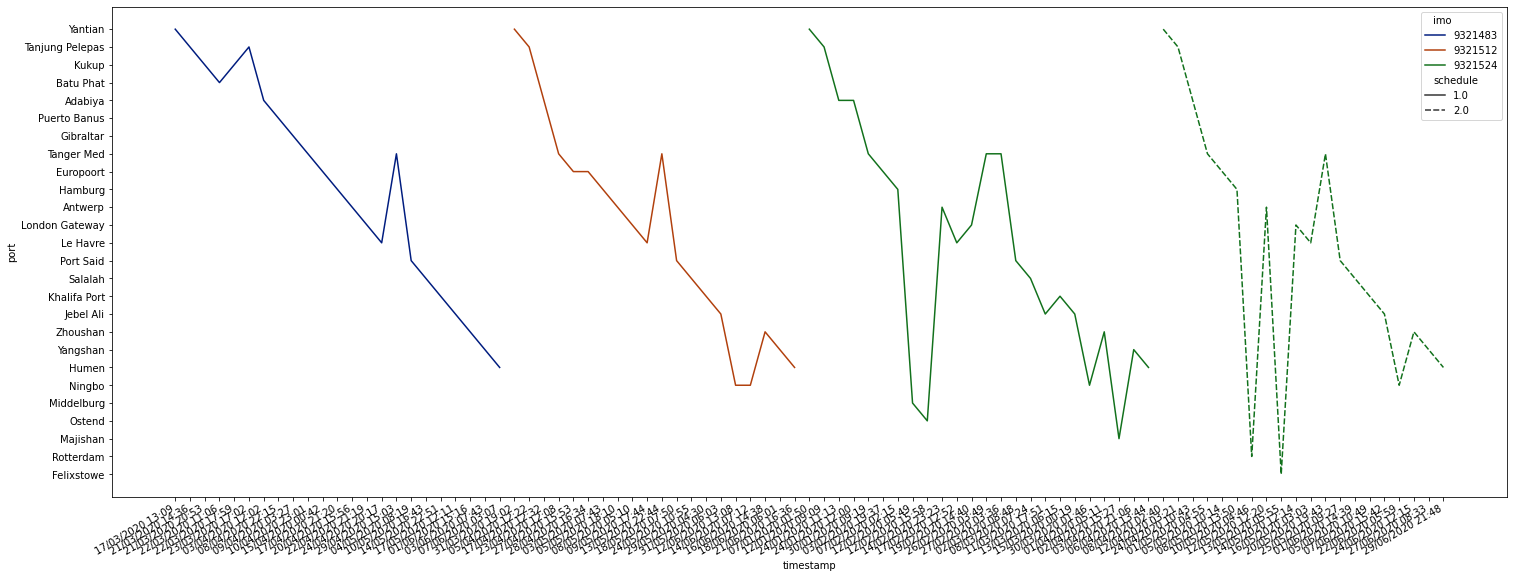

In [3]:
########## Ship's Service Pattern ##########
fig,ax = plt.subplots(figsize=(25,10))
service1_ports = service1_df[pd.notnull(service1_df['port'])]

sns.lineplot(x='timestamp', y='port', hue='imo', style='schedule', palette='dark', data=service1_ports)
fig.autofmt_xdate()
#service1_ports.to_csv('service1_ports.csv')

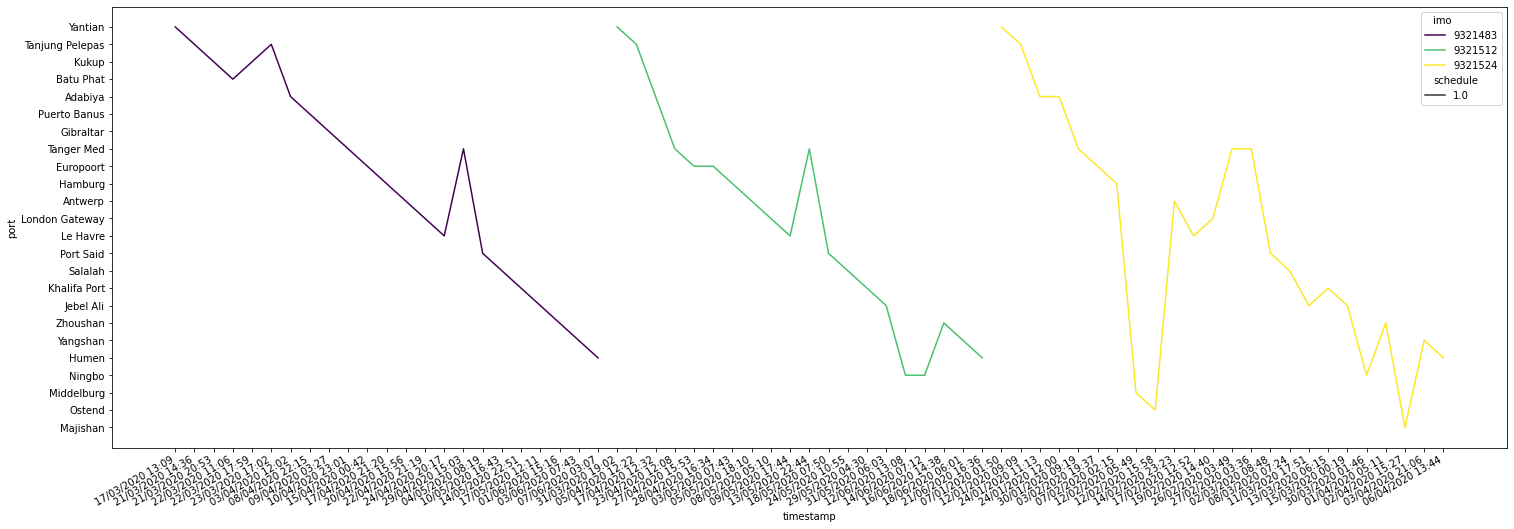

In [41]:
service1_df_imo = service1_ports.query('imo in [9321483, 9321512, 9321524] and schedule==1')
fig,ax = plt.subplots(figsize=(25,9))

sns.lineplot(x='timestamp', y='port', hue='imo', style='schedule', palette='viridis', data=service1_df_imo)
fig.autofmt_xdate()

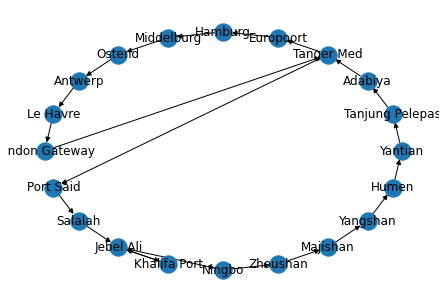

In [36]:
########## Network graph of a specific voyage in Service 1 ##########
service1_ports_by_imo = service1_ports.query('imo==9321524 and schedule==1')

trips = (
    service1_ports_by_imo
    .groupby(["port", "port_to"])
    .count()
    .reset_index()
    .select_columns(
        [
            "port", 
            "port_to", 
            "tripid"
        ]
    )
    .rename_column("tripid", "num_trips")
)

schedule_9321524 = nx.MultiDiGraph()

schedule_9321524 = nx.from_pandas_edgelist(service1_ports_by_imo, source='port', target='port_to',
                                          edge_attr=["schedule"],
                                          create_using=nx.MultiDiGraph())
#nx.draw(schedule, with_labels=True, font_weight='bold')
nx.draw_circular(schedule_9321524, with_labels=True)
#nx.draw_shell(schedule_9321524, with_labels=True)
#nx.draw_kamada_kawai(schedule_9321524, with_labels=True)

In [37]:
# List Nodes in the Schedule
nodes = schedule_9321524.nodes()
list(nodes)

['Yantian',
 'Tanjung Pelepas',
 'Adabiya',
 'Tanger Med',
 'Europoort',
 'Hamburg',
 'Middelburg',
 'Ostend',
 'Antwerp',
 'Le Havre',
 'London Gateway',
 'Port Said',
 'Salalah',
 'Jebel Ali',
 'Khalifa Port',
 'Ningbo',
 'Zhoushan',
 'Majishan',
 'Yangshan',
 'Humen']

In [38]:
# List Edges in the Schedule
edges = list(schedule_9321524.edges())
edges

[('Yantian', 'Tanjung Pelepas'),
 ('Tanjung Pelepas', 'Adabiya'),
 ('Adabiya', 'Adabiya'),
 ('Adabiya', 'Tanger Med'),
 ('Tanger Med', 'Europoort'),
 ('Tanger Med', 'Tanger Med'),
 ('Tanger Med', 'Port Said'),
 ('Europoort', 'Hamburg'),
 ('Hamburg', 'Middelburg'),
 ('Middelburg', 'Ostend'),
 ('Ostend', 'Antwerp'),
 ('Antwerp', 'Le Havre'),
 ('Le Havre', 'London Gateway'),
 ('London Gateway', 'Tanger Med'),
 ('Port Said', 'Salalah'),
 ('Salalah', 'Jebel Ali'),
 ('Jebel Ali', 'Khalifa Port'),
 ('Jebel Ali', 'Ningbo'),
 ('Khalifa Port', 'Jebel Ali'),
 ('Ningbo', 'Zhoushan'),
 ('Zhoushan', 'Majishan'),
 ('Majishan', 'Yangshan'),
 ('Yangshan', 'Humen'),
 ('Humen', 'Yantian')]

In [39]:
# List Degree Centrality of each Node in the Schedule
deg_centrality = list(nx.degree_centrality(schedule_9321524).items())
deg_centrality

[('Yantian', 0.10526315789473684),
 ('Tanjung Pelepas', 0.10526315789473684),
 ('Adabiya', 0.21052631578947367),
 ('Tanger Med', 0.3157894736842105),
 ('Europoort', 0.10526315789473684),
 ('Hamburg', 0.10526315789473684),
 ('Middelburg', 0.10526315789473684),
 ('Ostend', 0.10526315789473684),
 ('Antwerp', 0.10526315789473684),
 ('Le Havre', 0.10526315789473684),
 ('London Gateway', 0.10526315789473684),
 ('Port Said', 0.10526315789473684),
 ('Salalah', 0.10526315789473684),
 ('Jebel Ali', 0.21052631578947367),
 ('Khalifa Port', 0.10526315789473684),
 ('Ningbo', 0.10526315789473684),
 ('Zhoushan', 0.10526315789473684),
 ('Majishan', 0.10526315789473684),
 ('Yangshan', 0.10526315789473684),
 ('Humen', 0.10526315789473684)]

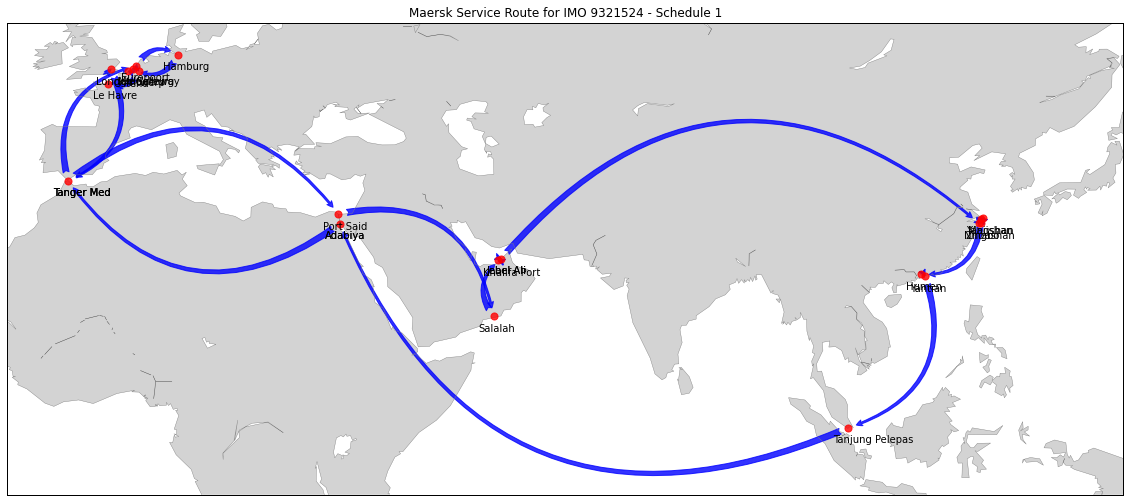

In [30]:
########## Plotting the Network in Geospace map ##########
fig,ax=plt.subplots(figsize=(20,10))
minlon = -179
minlat = -70
maxlon = 179
maxlat = 70
lat0 = (maxlat+minlat)/2
lon0 = (maxlon+minlon)/2
lat1 = (maxlat+minlat)/2-20
#m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,rsphere=(6378137.00,6356752.3142),resolution='l',projection='merc',lat_0=lat0,lon_0=lon0,lat_ts = lat1)
m=Basemap(llcrnrlon=-14, llcrnrlat=-8,urcrnrlon=142,urcrnrlat=58)
mx, my = m(service1_ports_by_imo['lng'].values, service1_ports_by_imo['lat'].values)
m.drawmapboundary(fill_color='white')
m.drawcoastlines(color='grey', linewidth=0.4)
m.fillcontinents(color='lightgrey',lake_color='white')
plt.title('Maersk Service Route for IMO 9321524 - Schedule 1')
labels = service1_ports_by_imo.port.values
for label, xpt, ypt in zip(labels, service1_ports_by_imo.lng.values, service1_ports_by_imo.lat.values):
    plt.annotate(label, xy=m(xpt, ypt), xycoords="data", xytext=(-15,-15), textcoords='offset pixels')
    
pos = {}
for count, elem in enumerate (service1_ports_by_imo['port']):
     pos[elem] = (mx[count], my[count])
pos

nx.draw_networkx_nodes(G = schedule_9321524, pos = pos, nodelist=list(schedule_9321524),
                        node_color = 'r', alpha = 0.8, node_size = 50)
nx.draw_networkx_edges(G = schedule_9321524, pos = pos, edge_color='b',
                        alpha=0.8, arrows = True, connectionstyle = 'arc3,rad=-0.5', arrowstyle='fancy', arrowsize=15)

#m.bluemarble()
#plt.tight_layout()
plt.show()

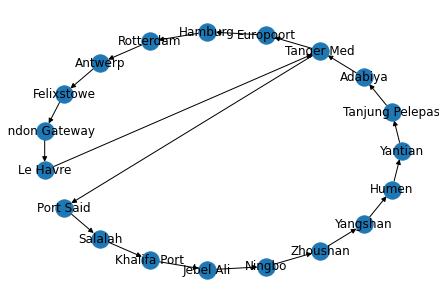

In [33]:
########## Network graph of a specific voyage in Service 1 ##########
service1_ports_by_imo = service1_ports.query('imo==9321524 and schedule==2')

trips = (
    service1_ports_by_imo
    .groupby(["port", "port_to"])
    .count()
    .reset_index()
    .select_columns(
        [
            "port", 
            "port_to", 
            "tripid"
        ]
    )
    .rename_column("tripid", "num_trips")
)

schedule_9321524 = nx.MultiDiGraph()

schedule_9321524 = nx.from_pandas_edgelist(service1_ports_by_imo, source='port', target='port_to',
                                          edge_attr=["schedule"],
                                          create_using=nx.MultiDiGraph())
#nx.draw(schedule, with_labels=True, font_weight='bold')
nx.draw_circular(schedule_9321524, with_labels=True)

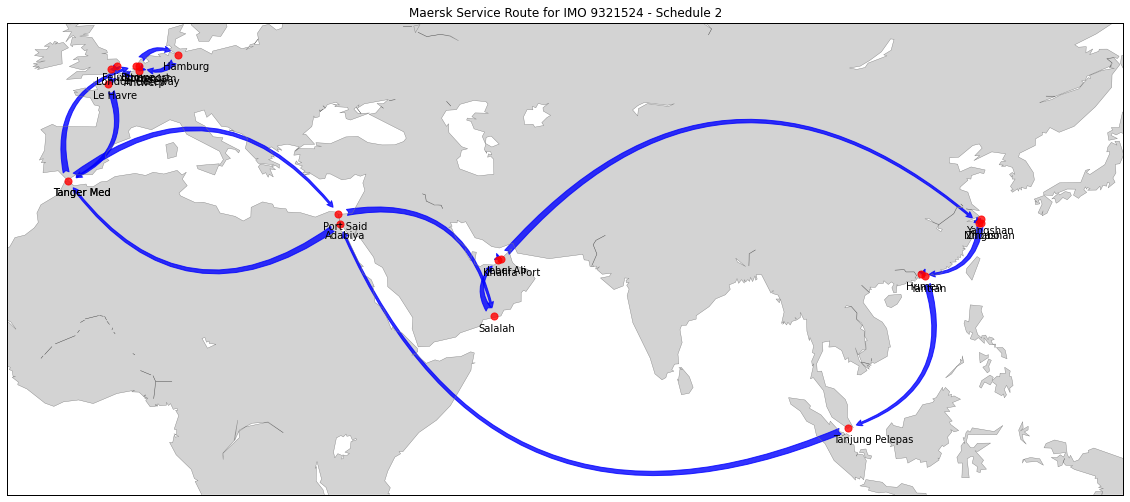

In [34]:
########## Plotting the Network in Geospace map ##########
fig,ax=plt.subplots(figsize=(20,10))
minlon = -179
minlat = -70
maxlon = 179
maxlat = 70
lat0 = (maxlat+minlat)/2
lon0 = (maxlon+minlon)/2
lat1 = (maxlat+minlat)/2-20
#m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,rsphere=(6378137.00,6356752.3142),resolution='l',projection='merc',lat_0=lat0,lon_0=lon0,lat_ts = lat1)
m=Basemap(llcrnrlon=-14, llcrnrlat=-8,urcrnrlon=142,urcrnrlat=58)
mx, my = m(service1_ports_by_imo['lng'].values, service1_ports_by_imo['lat'].values)
m.drawmapboundary(fill_color='white')
m.drawcoastlines(color='grey', linewidth=0.4)
m.fillcontinents(color='lightgrey',lake_color='white')
plt.title('Maersk Service Route for IMO 9321524 - Schedule 2')
labels = service1_ports_by_imo.port.values
for label, xpt, ypt in zip(labels, service1_ports_by_imo.lng.values, service1_ports_by_imo.lat.values):
    plt.annotate(label, xy=m(xpt, ypt), xycoords="data", xytext=(-15,-15), textcoords='offset pixels')
    
pos = {}
for count, elem in enumerate (service1_ports_by_imo['port']):
     pos[elem] = (mx[count], my[count])
pos

nx.draw_networkx_nodes(G = schedule_9321524, pos = pos, nodelist=list(schedule_9321524),
                        node_color = 'r', alpha = 0.8, node_size = 50)
nx.draw_networkx_edges(G = schedule_9321524, pos = pos, edge_color='b',
                        alpha=0.8, arrows = True, connectionstyle = 'arc3,rad=-0.5', arrowstyle='fancy', arrowsize=15)

#m.bluemarble()
#plt.tight_layout()
plt.show()

In [44]:
########## Stalled KPI Details Extraction ##########
stalled_kpi_s1 = pd.read_csv("Service_1.csv", header = 0)
stalled_kpi_s1 = stalled_kpi_s1.query('naviation_status in ["At Anchor", "Moored", "Under Way"] and speed < 3 and distance_from_nearest_port < 30 and schedule in [1,2]')

#stalled_kpi_s1['cum_ts_secs'] = stalled_kpi_s1.groupby(['imo', 'schedule', 'nearest_port_name'])['date_diff_secs'].cumsum()
#stalled_kpi_s1['ts_at_port'] = np.where(((stalled_kpi_s1['port'].notnull()) & (stalled_kpi_s1['port_to'] != stalled_kpi_s1['port'])), (stalled_kpi_s1['cum_ts_secs']), np.nan_to_num(0))

stalled_kpi_s1['cum_ts_secs'] = stalled_kpi_s1.groupby(['imo', 'schedule', 'nearest_port_name', 'naviation_status'])['date_diff_secs'].cumsum()
stalled_kpi_s1['ts_at_port'] = np.where(((stalled_kpi_s1['nearest_port_name'] != stalled_kpi_s1['nearest_port_name'].shift(-1))|(stalled_kpi_s1['naviation_status'] != stalled_kpi_s1['naviation_status'].shift(-1))), (stalled_kpi_s1['cum_ts_secs']), np.nan_to_num(0))

stalled_kpi_s1.to_csv('kpi_imo_s11.csv')
stalled_kpi_s1 = stalled_kpi_s1.query('ts_at_port > 0')
stalled_kpi_s1['Time_at_port'] = stalled_kpi_s1['ts_at_port'] // 3600
stalled_kpi_s1.to_csv('kpi_imo_s1.csv')

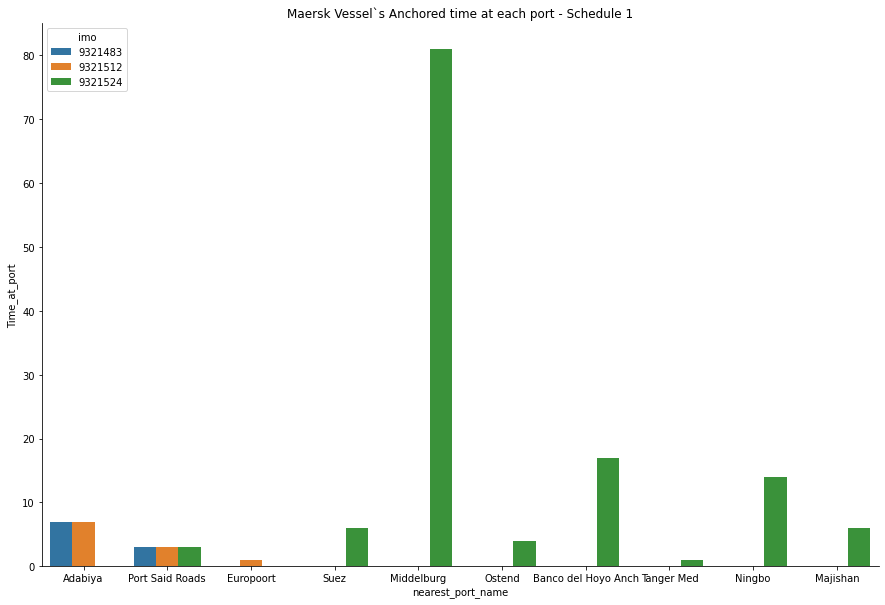

In [57]:
########## KPI - Anchored time at port for a specific voyage ##########
anchored_at_port = stalled_kpi_s1.query('naviation_status in ["At Anchor"] and schedule==1')

fig, ax1 = plt.subplots(figsize=(15, 10))
plt.title('Maersk Vessel`s Anchored time at each port - Schedule 1')
sns.barplot(x='nearest_port_name', y='Time_at_port', hue='imo', data=anchored_at_port, ax=ax1)
sns.despine(fig)

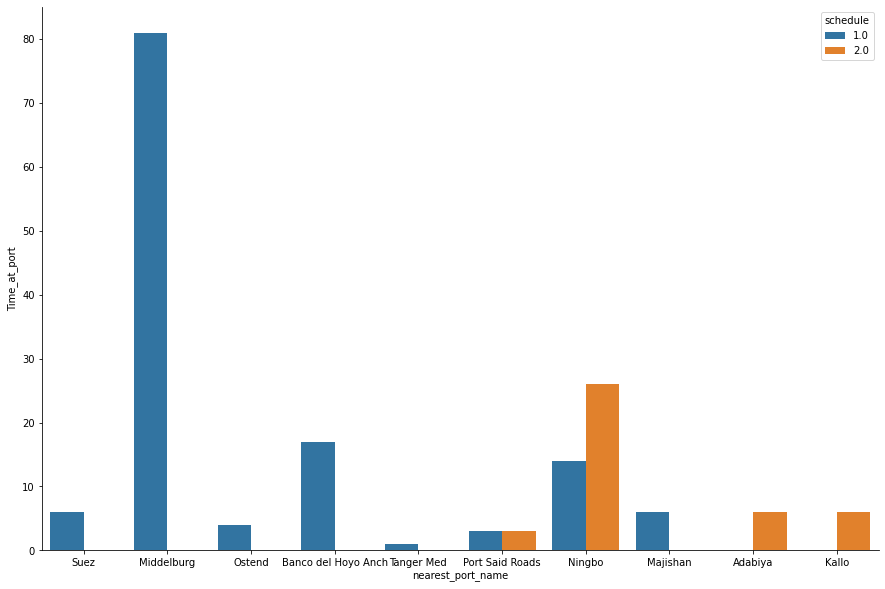

In [49]:
########## KPI - Anchored time at port for a specific IMO ##########
anchored_at_port = stalled_kpi_s1.query('naviation_status in ["At Anchor"] and imo==9321524')

fig, ax1 = plt.subplots(figsize=(15, 10))
#sns.barplot(x='Time_at_port', y='nearest_port_name', hue='schedule', data=anchored_at_port, ax=ax1)
sns.barplot(x='nearest_port_name', y='Time_at_port', hue='schedule', data=anchored_at_port, ax=ax1)
sns.despine(fig)

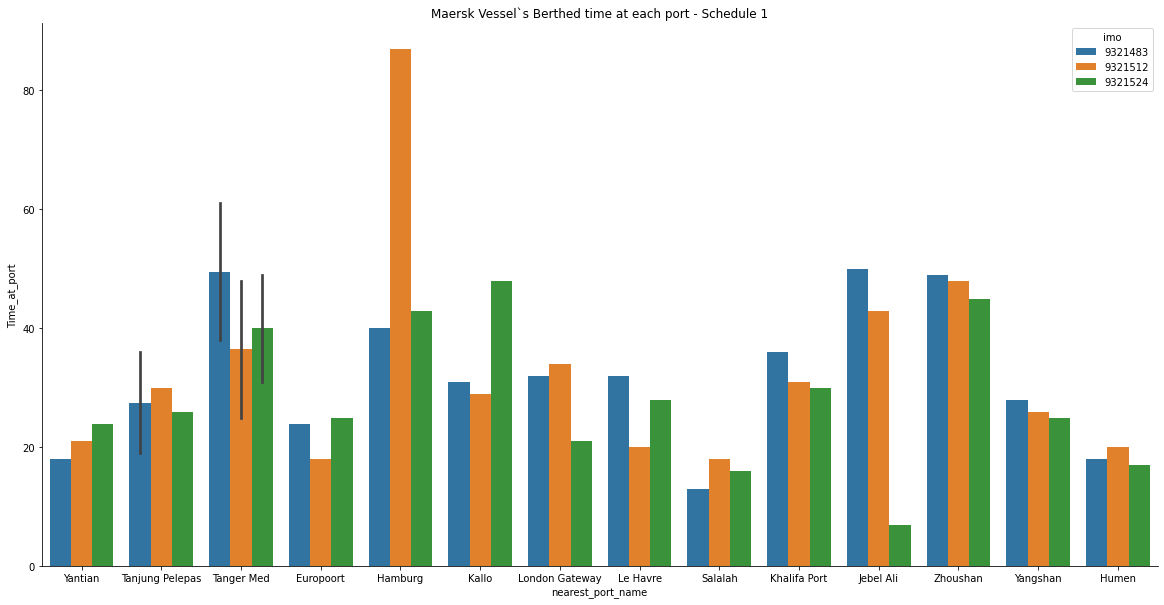

In [58]:
########## KPI - Moored time at port for a specific voyage ##########
moored_at_port = stalled_kpi_s1.query('naviation_status in ["Moored"] and schedule==1')

fig, ax1 = plt.subplots(figsize=(20, 10))
plt.title('Maersk Vessel`s Berthed time at each port - Schedule 1')
sns.barplot(x='nearest_port_name', y='Time_at_port', hue='imo', data=moored_at_port, ax=ax1)
sns.despine(fig)

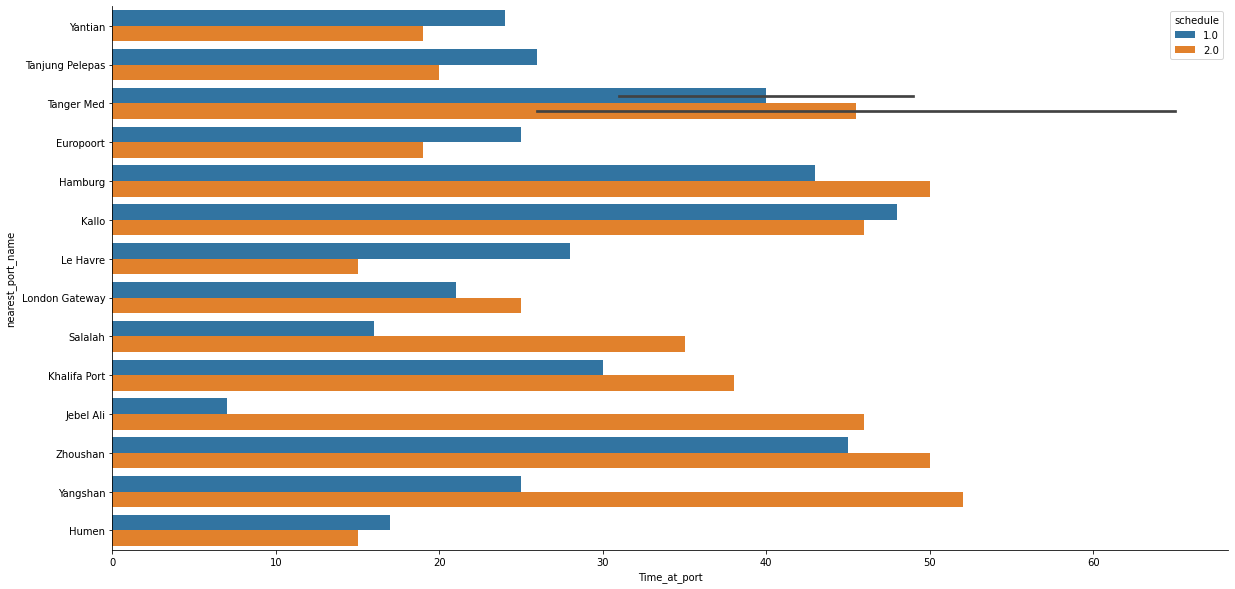

In [55]:
########## KPI - Moored time at port for a specific IMO ##########
moored_at_port = stalled_kpi_s1.query('naviation_status in ["Moored"] and imo==9321524')

fig, ax1 = plt.subplots(figsize=(20, 10))
sns.barplot(x='Time_at_port', y='nearest_port_name', hue='schedule', data=moored_at_port, ax=ax1)
sns.despine(fig)

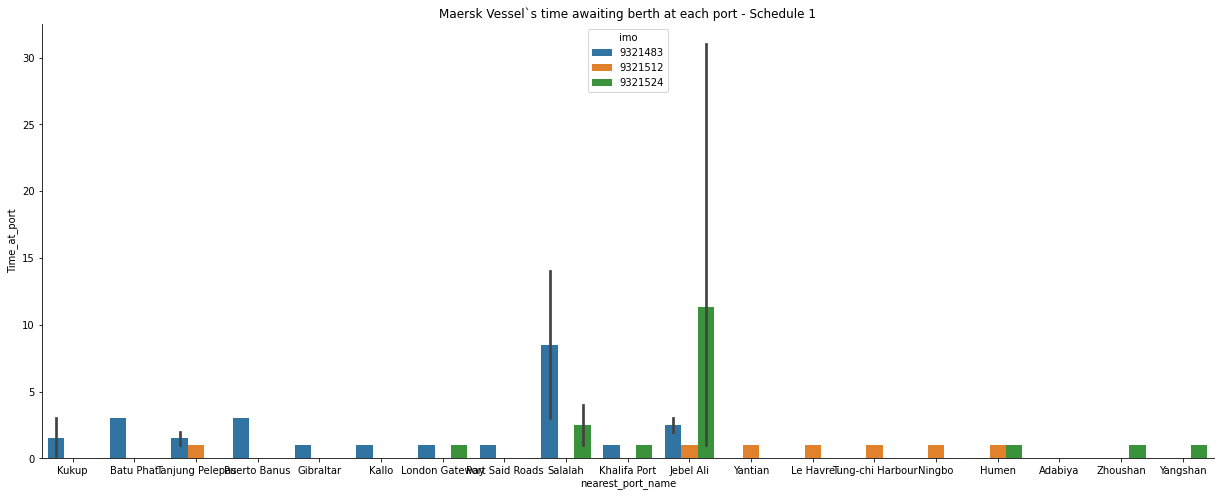

In [73]:
########## KPI - Underway time at port for a specific voyage ##########
underway_at_port = stalled_kpi_s1.query('naviation_status in ["Under Way"] and schedule==1')
fig, ax1 = plt.subplots(figsize=(21, 8))
plt.title('Maersk Vessel`s time awaiting berth at each port - Schedule 1')
sns.barplot(x='nearest_port_name', y='Time_at_port', hue='imo', data=underway_at_port, ax=ax1)
sns.despine(fig)

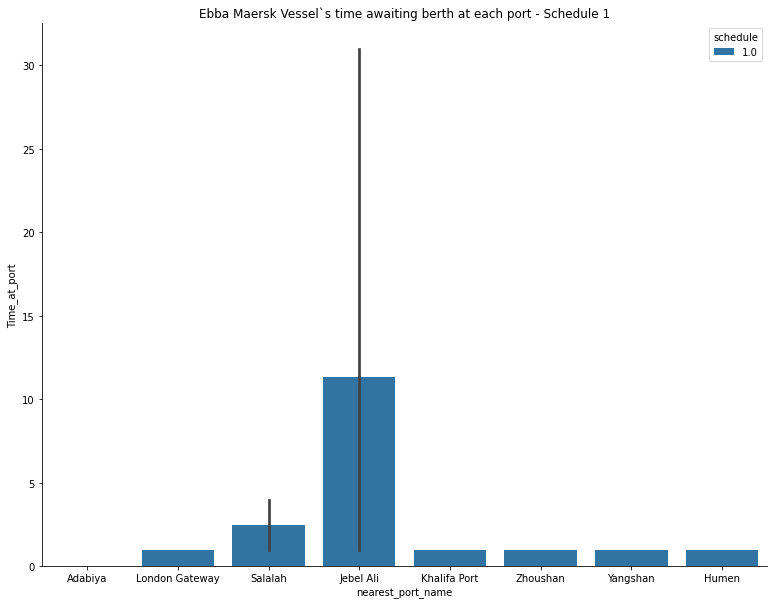

In [78]:
########## KPI - Underway time at port for a specific IMO ##########
underway_at_port = stalled_kpi_s1.query('naviation_status in ["Under Way"] and imo==9321524 and schedule==1')

fig, ax1 = plt.subplots(figsize=(13, 10))
plt.title('Ebba Maersk Vessel`s time awaiting berth at each port - Schedule 1')
sns.barplot(x='nearest_port_name', y='Time_at_port', hue='schedule', data=underway_at_port, ax=ax1)
sns.despine(fig)

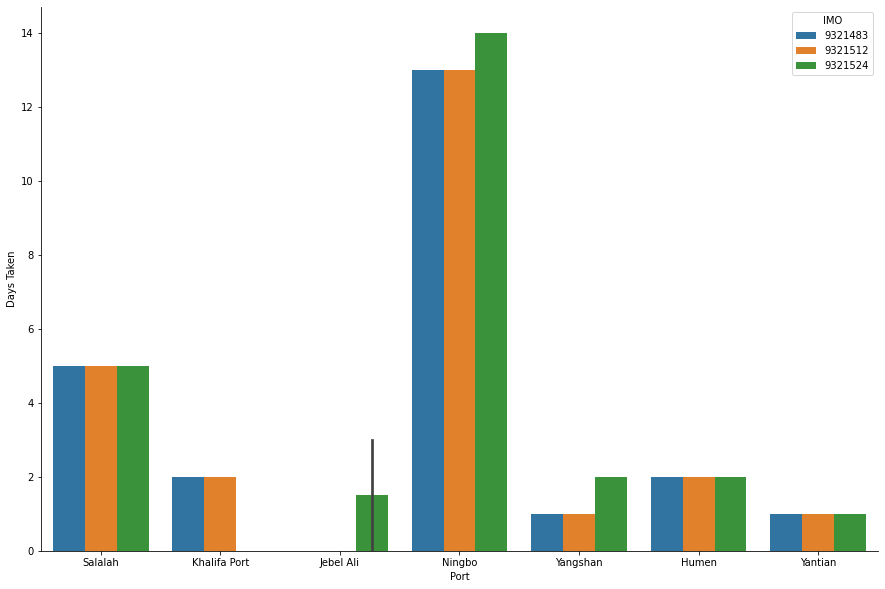

In [14]:
delay_from_eta = pd.read_csv("delay.csv", header = 0)

fig, ax1 = plt.subplots(figsize=(15, 10))
sns.barplot(x='Port', y='Days Taken', hue='IMO', data=delay_from_eta, ax=ax1)
sns.despine(fig)

In [11]:
########## Sailing KPI Details Extraction ##########
sailing_kpi_s1 = pd.read_csv("Service_1.csv", header = 0)

sailing_kpi_s1 = sailing_kpi_s1.query('naviation_status in ["Under Way", "Under way sailing"] and speed > 3 and distance_from_nearest_port > 30 and schedule in [1,2]')
sailing_kpi_s1 = sailing_kpi_s1.sort_values(by=['imo','timestamp','schedule'])
sailing_kpi_s1['cum_speed_service'] = sailing_kpi_s1.groupby(['imo','schedule'])['speed'].cumsum()
sailing_kpi_s1.to_csv('sailing_kpi_s1_speed.csv')

In [87]:
# Average speed when sailing
avg=sailing_kpi_s1.groupby(['imo','schedule','destination'])['speed'].mean()
avg

imo      schedule  destination  
9321483  1.0       AEJEA-CNNBO      17.901515
                   CNYAT-MYTPP      19.150000
                   CNYSN-CNNSA      11.300000
                   EGSCN-MAPTM      16.647826
                   EGSCN-OMSLV      17.370968
                   FRLEH< MAPTM     13.741935
                   MAPTM-NLRTM      21.170000
                   MAPTM< EGSCN     17.496296
                   MYTPP<EGSCN      20.075000
                   OMSLV-AEKHL      16.822222
9321512  1.0       AEJAL-CNNPO      17.364865
                   CNSGH-CNNAN      14.966667
                   CNYAT-MYTPP      18.800000
                   EG SUZ-MAPTM     18.693333
                   EGSUC-OMSLV      17.012903
                   FRLEH-MAPTM      15.975862
                   MAPTM-EGSUC      19.161538
                   MAPTM-NLROT      15.900000
                   MYTPP -EG SUZ    17.657843
                   OMSLV-AEAUH      14.755000
9321524  1.0       BE ANT            9.150000
 

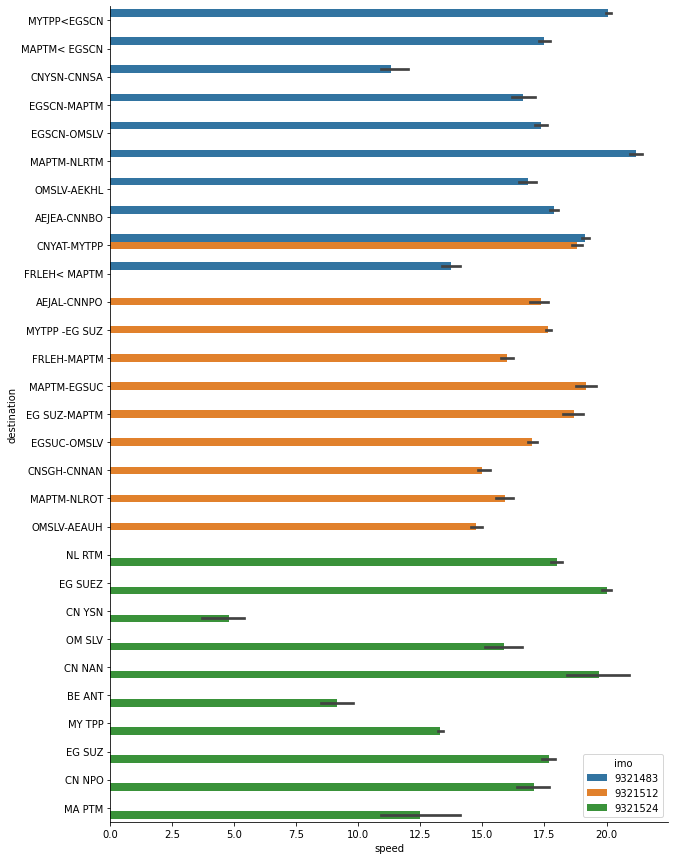

In [85]:
########## Mean speed for a specific voyage ##########
sailing = sailing_kpi_s1.query('schedule==1')

fig, ax1 = plt.subplots(figsize=(10, 15))
sns.barplot(x='speed', y='destination', hue='imo', data=sailing, ax=ax1)
sns.despine(fig)

In [53]:
# Identify delay at each port
delay_kpi_s1 = pd.read_csv("Service_1.csv", header = 0, parse_dates = ['timestamp','eta'],dayfirst=True)
delay_kpi_s1 = delay_kpi_s1.query('naviation_status in ["At Anchor", "Moored", "Under Way"] and speed < 3 and distance_from_nearest_port < 30 and schedule in [1,2]')

delay_kpi_s1['delay'] = delay_kpi_s1['timestamp'] - delay_kpi_s1['eta']
delay_kpi_s1['delay_at_port'] = np.where(((delay_kpi_s1['port'].shift(1).notnull()) & (delay_kpi_s1['nearest_port_name'] != delay_kpi_s1['port'].shift(1))), (delay_kpi_s1['delay'].dt.total_seconds()), np.nan_to_num(0))
delay_kpi_s1.to_csv('delay_kpi.csv')
delay_kpi_s1 = delay_kpi_s1.query('delay_at_port > 0')
delay_kpi_s1['delay_at_port (Hr)'] = delay_kpi_s1['delay_at_port'] // (3600)
delay_kpi_s1.to_csv('delay_kpi_s1.csv')

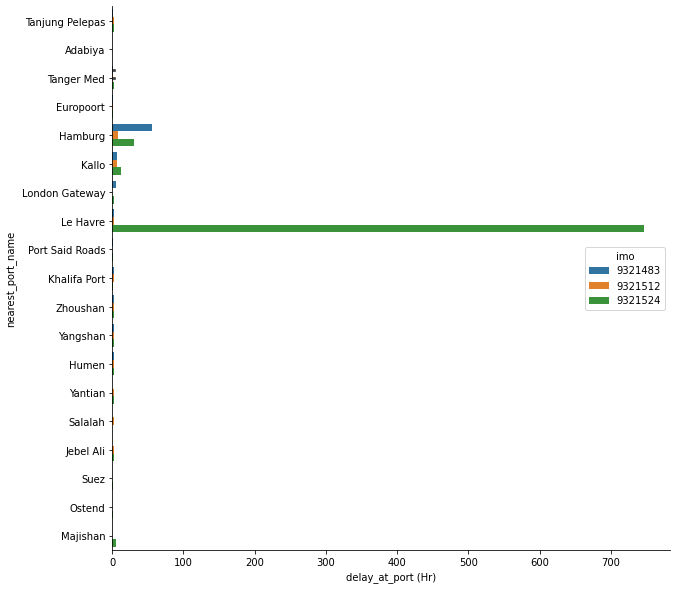

In [54]:
# Delay at each port for a specific voyage
delay_at_port = delay_kpi_s1.query('schedule == 1')

fig, ax1 = plt.subplots(figsize=(10, 10))
sns.barplot(x='delay_at_port (Hr)', y='nearest_port_name', hue='imo', data=delay_at_port, ax=ax1)
sns.despine(fig)